In [1]:
import lightkurve as lk
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as plt
import pandas as pd

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

%matplotlib inline

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


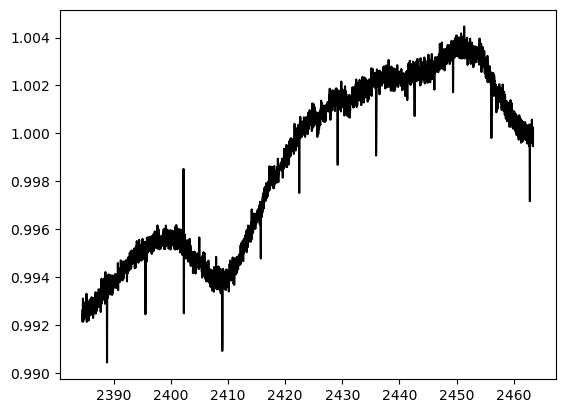

In [4]:
df = pd.read_csv('k2camp1.dat',sep='\t',names='time flux fluxerr inst'.split())

time = (df['time'] - 2454833).values
flux = df['flux'].values
flux_error = df['fluxerr'].values

# plt.figure()
# plt.plot(time, flux, 'k')
# plt.xlim(2396, 2402)

plt.figure()
plt.plot(time, flux, 'k')

# plt.xlim(2384, 2464)
# plt.ylim(0.9967,1.001)



(2408.75, 2415.9)

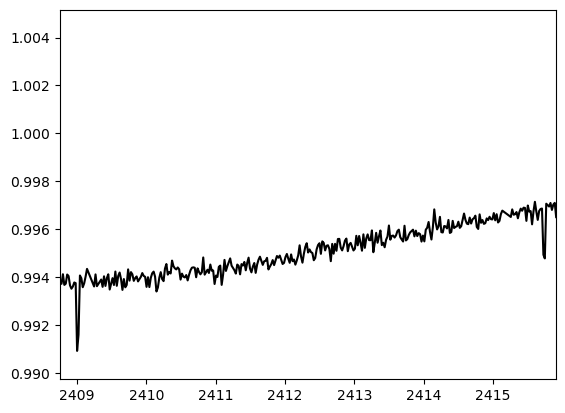

In [181]:
plt.plot(time, flux, 'k')
plt.xlim(2408.75, 2415.9)
# plt.ylim(0.990, 0.995)

{'index': 85, 'log_power': -18.040985769651343, 'period': 5.640310549838081, 'period_uncert': 0.11634187152705437}


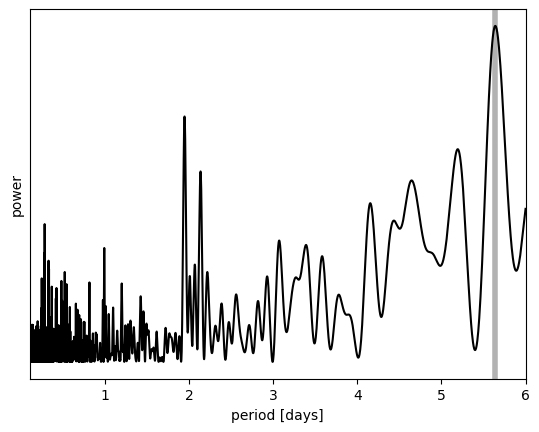

In [5]:
results = xo.estimators.lomb_scargle_estimator(
    time, flux, max_peaks=2, min_period = 0.1, max_period = 6, samples_per_peak = 100
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")
print(peak)

In [6]:
periods = 6.7252337648
period_error = 0.1
t0s = 2457221.8349184883 - 2454833 #[2388.835, 3380.822]
t0_error = 0.1
duration = [0.9/24, 15.71/24]
nplanets = 1
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
# ecc_fit = True

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(time), dtype=bool)

    with pm.Model() as model:
        
        mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
        u_star = xo.distributions.QuadLimbDark("u_star")

        # Stellar parameters
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
        teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
        st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
        star_params = [mean, u_star] 
    
##########Planet Parameters##########Planet Parameters##########Planet Parameters######

        ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) # *varying 
        r_pl = pm.Deterministic("r_pl", ror*r_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step

    
##########Orbital Parameters##########Orbital Parameters##########Orbital Parameters###

        period = pm.Normal("period", mu = periods, sigma = period_error, shape=nplanets)    
        t0 = pm.Normal("t0", mu=t0s, sigma = t0_error, shape = nplanets)
        b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)

        # Set up the Orbit

        ecs = pmx.UnitDisk("ecs", testval = np.array([0.1, 0.1]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", 
            multi=False, 
            shape=1, 
            fixed=True, 
            observed=ecc
        )

        # Define the Orbit Model ************************************************
        orbit = xo.orbits.KeplerianOrbit(
            r_star = r_star, 
            m_star= m_star, 
            period = period, 
            t0 = t0, 
            b = b, 
            ecc = ecc,
            omega = omega)

        pm.Deterministic("rho_circ", orbit.rho_star)
        pm.Deterministic("aor", orbit.a / r_star)

        # Define the Mean Transit Model *****************************************
        star = xo.LimbDarkLightCurve(u_star)

        # Calculates light curve for each planet at its time vector 
        light_curves = star.get_light_curve(
            orbit = orbit, 
            r = r_pl, 
            t=time[mask], 
            texp = 29.4*u.min.to('d')
        )

        # Saves the individual lightcurves 
        pm.Deterministic("light_curves", light_curves)

        lc_model = mean + tt.sum(light_curves, axis=-1) # full photometric model, 
                                                        # the sum of all transits + 
                                                        # the baseline (mean)

        # The likelihood function assuming known Gaussian uncertainty
    #     pm.Normal("obs", mu=lc_model, sd=flux_error, observed=flux)

    
################################# ################################# 
########## GP MODEL ############# ########## GP MODEL #############
################################# #################################
    
        # A jitter term describing excess white noise
        jitter = pm.Normal("jitter", mu = np.mean(flux_error[mask]), sigma = 2.0)

        # The parameters of the RotationTerm Kernel 
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 6.0)
        )
        prot = pm.Normal("prot", mu = 5.640310549838081, sigma = 0.12)
        Q0 = pm.Normal("Q0", mu = 7.5, sigma = 2) 
        dQ = pm.Normal("dQ", mu = 7.5, sigma = 2)
        f = pm.Uniform("f", lower = 0.1, upper = 1.0)

        # Set up the Gaussian Process Model (using a quasiperiodic term)
        kernel = terms.RotationTerm(
            sigma = sigma_rot, 
            period = prot, 
            Q0 = Q0, 
            dQ = dQ, 
            f = f,
        )
    
        # Note: Mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        gp = GaussianProcess(
            kernel,
            t = time[mask],
            diag = flux_error[mask]**2 + tt.exp(2*jitter),
            quiet = True,
        )

        # Compute the Gaussian Process Likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("no_transit_lc", observed = flux[mask] - lc_model) # Removing the transit depths

        # Compute the GP Model Prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(flux[mask] - lc_model))
    
################################# ################################################################## 
########## OPTIMIZING ########### ########## OPTIMIZING ##################### OPTIMIZING ###########
################################# ##################################################################                        

        # Optimizing the MAP solution
        if start is None:
            start = model.test_point

        map_soln = start 
        
        print(model.check_test_point())
    
        # Optimizing GP model 
        map_soln = pmx.optimize(vars=[sigma_rot, f, prot, Q0, dQ])

        # Optimizing LC model
        map_soln = pmx.optimize(
            vars=[
                ror,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                u_star,
                mean,
            ],
        )    
        map_soln = pmx.optimize(start = map_soln)
        
    return model, map_soln


model, map_estimate = build_model()

mean                         -1.42
u_star_quadlimbdark__        -2.77
m_star_interval__            -1.12
r_star_interval__             0.01
teff_interval__              -7.10
ror_interval__               -1.39
period                        1.38
t0                            1.38
b_interval__                 -1.39
ecs_unitdisk+interval__      -1.41
jitter                       -1.61
sigma_rot_log__               0.00
prot                          1.20
Q0                           -1.61
dQ                           -1.61
f_interval__                 -1.39
ecc_prior                     0.00
no_transit_lc             -3513.48
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [dQ, Q0, prot, f, sigma_rot]


message: Optimization terminated successfully.
logp: -3530.9795385458497 -> -3407.155552089426
optimizing logp for variables: [mean, u_star, r_star, period, t0, ecs, b, ror]


message: Optimization terminated successfully.
logp: -3530.9795385458497 -> -3528.1696170975147
optimizing logp for variables: [f, dQ, Q0, prot, sigma_rot, jitter, ecs, b, t0, period, ror, teff, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -3528.1696170975147 -> 21903.540079778053


In [7]:
# print('*** MAP Fit Parameters ***')
# for thiskey in list(map_soln.keys())[:-1]:
#     if bool(thiskey.find('__')+1):
#         continue
#     print('{}: {}'.format(thiskey, map_soln[thiskey]))
    
# Changed lines 2 & 5 above: map_soln to map_estimate
print('*** MAP Fit Parameters ***')
for thiskey in list(map_estimate.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_estimate[thiskey]))
    
    
    

*** MAP Fit Parameters ***
mean: 0.9924708012657969
period: [5.7088991]
t0: [2388.55488581]
jitter: -13.071901508430779
prot: 6.549119511153653
Q0: 22.270182011363
dQ: 15.786626529271583
u_star: [2.92963931e-07 5.18865378e-01]
m_star: 0.019343444250431094
r_star: 1.4647660899107215
teff: 4803.938741566283
st_lum: 1.0259281052339502
ror: [0.02167589]
r_pl: [0.03175011]
b: [0.00444955]
ecs: [0.5662251  0.17125263]
ecc: 0.34993832521003854
omega: 0.29369949835567993
rho_circ: 0.00867721314151276
aor: [2.46347992]
light_curves: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
sigma_rot: 0.05389101200768751
f: 0.10529823177267139


In [12]:
import matplotlib as mpl


def plot_light_curve(time, flux, soln, mask=None):
    if mask is None:
        mask = np.ones(len(time), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
    
####### First Plot ###### ####### First Plot ###### ####### First Plot ######

    ax = axes[0]

#     if len(time[mask]) > int(2e4):
#         # see https://github.com/matplotlib/matplotlib/issues/5907
#         mpl.rcParams["agg.path.chunksize"] = 10000
    
    ########  Plotting data...########  Plotting data...########  Plotting data...
    ax.scatter(
        time[mask],
        flux[mask],
        c = "k", # color
        s = 0.5, # point size
        rasterized = True,
        label = "data",
        linewidths = 0,
        zorder = 42, # what does zorder mean again?
    )

    # The MAP GP Model is defined by: 
    gp_mod = soln["gp_pred"] + soln["mean"] ## Apparently map_soln and soln can be used interchangeably?
    
    # Plotting the MAP GP Model AKA Green Line
    ax.plot(
        time[mask], gp_mod, color = "C2", label = "MAP gp model", zorder = 41, lw = 0.5
    )
    ax.legend(fontsize=15)
    ax.set_ylabel("$f$")
    
################## 2nd Plot ####################### Data minus MAP gp model ##################
    ax = axes[1]
    
    ax.plot(time[mask], flux[mask] - gp_mod, "k", label = "data - MAPgp") # ********
    
    for i, l in enumerate("b"): #Plotting the light curves
        mod = soln["light_curves"][:, i]
        ax.plot( 
            time[mask],
            mod,
            label="planet {0} [model under]".format(l),
            zorder=-10,
        )
        
    # Labels #
    ax.legend(fontsize=15, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")
    
########################## Plotting Planet Transits Against Data - MAP GP Model ############################
    ax = axes[2]
    
    ax.plot(time[mask], flux[mask] - gp_mod, "k", label = "data - MAPgp") # ********
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(time[mask], mod, label="planet {0} [model over]".format(l))
        
    # Labels #    
    ax.legend(fontsize=15, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
#     flux_min = np.min(mod) - 0.05 * abs(np.min(mod))
#     flux_max = abs(flux_min)
#     ax.set_ylim([flux_min, flux_max])
    
########### Adding GP Model + Sum of All Light Curves Then Subtracting That Result To Get Final Product? ###
    ax = axes[3]
    
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(time[mask], flux[mask] - mod, "k") # ********
    
    # Labels #
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
#     ax.set_xlim(time[mask].min(), time[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

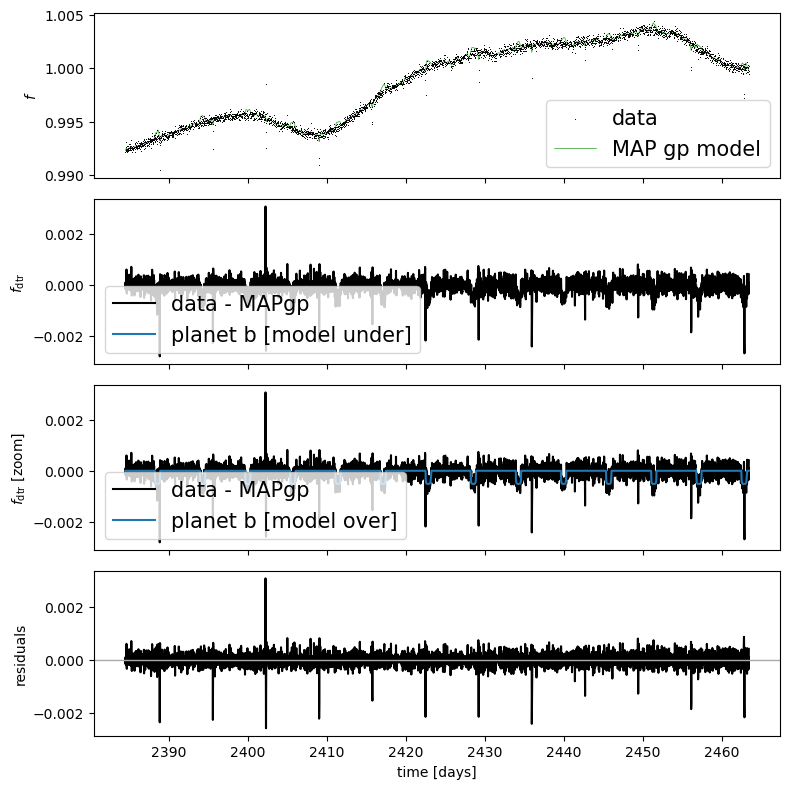

In [13]:
plot_light_curve(time, flux, map_estimate)
# plot_light_curve(time, flux, map_soln["light_curves"])


In [38]:
def plot_light_curve(time, flux, soln, mask=None):
    if mask is None:
        mask = np.ones(len(time), dtype=bool)

    ########  Plotting data...########  Plotting data...########  Plotting data...
    plt.figure()
    plt.scatter(
        time[mask],
        flux[mask],
        c = "k", # color
        s = 2, # point size
        rasterized = True,
        label = "data",
        linewidths = 0,
        zorder = 42, # what does zorder mean again?
    )

        # The MAP GP Model is defined by: 
    gp_mod = soln["gp_pred"] + soln["mean"] ## Apparently map_soln and soln can be used interchangeably?

        # Plotting the MAP GP Model AKA Green Line
    plt.plot(time[mask], gp_mod, color = "C2", label = "MAP gp model", zorder = 41, lw = 1)
    plt.legend(fontsize=10)
#     plt.xlim(2430, 2460)
    plt.ylabel("$f$")

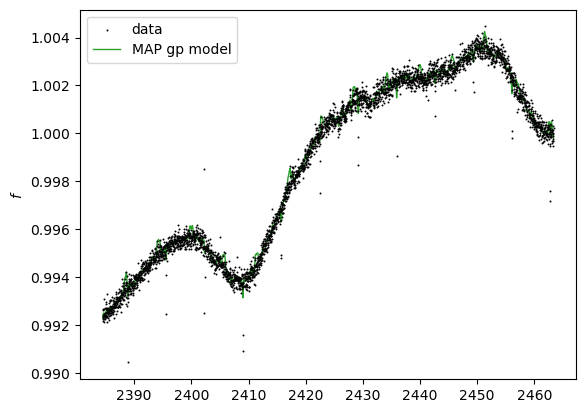

In [39]:
plot_light_curve(time, flux, map_estimate)

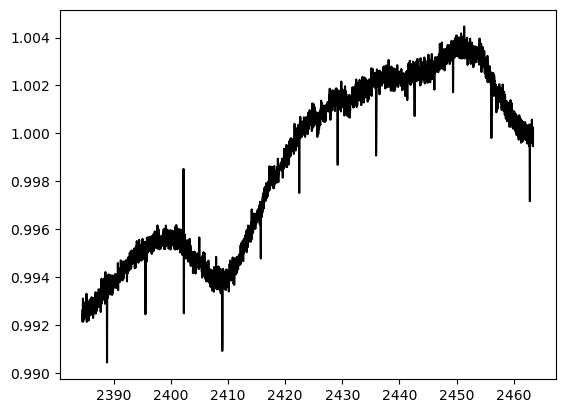

In [27]:
plt.figure()
plt.plot(time, flux, 'k')